# Sales Forecasting With Machine Learning 

The purpose of this project is to demnostrate applied machine learning in the retail domain. 

Situation: Walmart launched an initative to crowd source machine learning models that could be used to forecast store sales. Walmart provided historical sales data for 45 stores located in different regions. In addition, Walmart included promotional markdown event data. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. Walmart requested models prioritize forecasting accuracy during these markdown events despite incomplete historical data.

Task: Predict the department-wide weekly sales for each store while prioritizing weeks with holiday markdown events.

Action: The following documnention reflects the process I followed to create a machine learning model that forecasts sales. 

## Libraries and Data Loading

First step was to import the necessary data and packages into a python environment.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
from scipy.special import boxcox1p

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore") # ignoring annoying warnings

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

features = pd.read_csv('/Users/aidan/Documents/Jupyter Storage/Walmart Forecasting/features.csv')
train = pd.read_csv('/Users/aidan/Documents/Jupyter Storage/Walmart Forecasting/train.csv')
stores = pd.read_csv('/Users/aidan/Documents/Jupyter Storage/Walmart Forecasting/stores.csv')
test = pd.read_csv('/Users/aidan/Documents/Jupyter Storage/Walmart Forecasting/test.csv')
sample_submission = pd.read_csv('/Users/aidan/Documents/Jupyter Storage/Walmart Forecasting/sampleSubmission.csv')


## Data Cleaning and Exploritory Analysis

In this section I explore the data sets provided, join pertinent information, and make relevant transformations. To establish context here is a description of each data set. 

#### stores.csv
This file contains anonymized information about the 45 stores, indicating the type and size of store.

#### train.csv
This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file are the following fields:

- Store - the store number
- Dept - the department number
- Date - the week
- Weekly_Sales -  sales for the given department in the given store
- IsHoliday - whether the week is a special holiday week

This data set set will be used to train the model and test accuracy.

#### test.csv
This file is identical to train.csv, except weekly sales are withheld. This data set will be used to predict the sales for each triplet of store, department, and date in this file.

#### features.csv
This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

- Store, the store number
- Date,  the week
- Temperature, average temperature in the region
- Fuel_Price, cost of fuel in the region
- MarkDown1-5, anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
- CPI, the consumer price index
- Unemployment, the unemployment rate
- IsHoliday, whether the week is a special holiday week

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are identified in the data):
- Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
- Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
- Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
- Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

With the preface covered the next step is to merge relevant data sets: features and stores. Joing the two tables with the common store ID creates a new table for the exploratory analysis. 

In [3]:
feat_sto = features.merge(stores, how='inner', on='Store')

feat_sto.head(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


It's important to check the data types in the new table to prevent any errors down the line.

In [4]:
pd.DataFrame(feat_sto.dtypes, columns=['Type'])

,Type
Store,int64
Date,object
Temperature,float64
Fuel_Price,float64
MarkDown1,float64
MarkDown2,float64
MarkDown3,float64
MarkDown4,float64
MarkDown5,float64
CPI,float64


Notice the 'Date' field has a string type. We'll convert to 'datetime'and check the 'train' and 'test' dataframes for 'Date' types as well. 

In [5]:
train.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [6]:
pd.DataFrame({'Type_Train': train.dtypes, 'Type_Test': test.dtypes})

,Type_Train,Type_Test
Date,object,object
Dept,int64,int64
IsHoliday,bool,bool
Store,int64,int64
Weekly_Sales,float64,NaN


In [7]:
feat_sto.Date = pd.to_datetime(feat_sto.Date)
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

The 'Date' field doesn't represent the day itself, but each week, ending every friday. It's useful to create a 'Week' and 'Year' field. 

In [8]:
feat_sto['Week'] = feat_sto.Date.dt.week 
feat_sto['Year'] = feat_sto.Date.dt.year

We can create two new dataframes 'train_detail' and 'test_detail' containing all the information we need, joining 'train' and 'test' with 'feat_sto'. The keys here can be 'Store', 'Dept' and 'IsHoliday'.

In [9]:
train_detail = train.merge(feat_sto, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

test_detail = test.merge(feat_sto, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

Another essential step is to assess what data is missing from our tables. To do so I search for null values in each field. 

In [10]:
null_columns = (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False).index
null_data = pd.concat([
    train_detail.isnull().sum(axis = 0),
    (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False),
    train_detail.loc[:, train_detail.columns.isin(list(null_columns))].dtypes], axis=1)
null_data = null_data.rename(columns={0: '# null', 
                                      1: '% null', 
                                      2: 'type'}).sort_values(ascending=False, by = '% null')
null_data = null_data[null_data["# null"]!=0]
null_data

,# null,% null,type
MarkDown2,310322,0.736110,float64
MarkDown4,286603,0.679847,float64
MarkDown3,284479,0.674808,float64
MarkDown1,270889,0.642572,float64
MarkDown5,270138,0.640790,float64


I'll be utilizing a random forest machine learning technique which can be distorted by null values and attemps to inmpute subsitutes. Upon closer inspection the null entires are not "no markdown" but missing records. Between 2010-2011 nearly all mark down data is misisng. Considering a significant number of weeks are missing markdowns adjustments may be required depending of the correlations of these markdowns. 

#### Holiday Review

The data provided included the disclosure that only the following holidays were marked as such. 

- Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
- Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
- Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
- Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

One holiday excluded is Easter, which we will mark in the "IsHoliday" field. To determine any other excluded holidays or similar events let's review the Average Weekly Sales per Year for unaccount sales peaks.

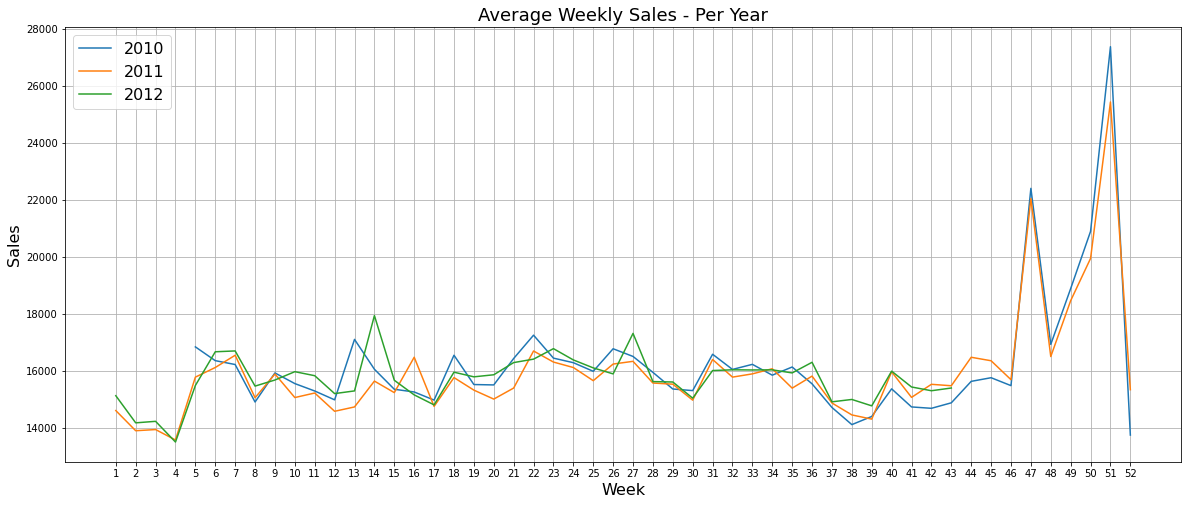

In [11]:
weekly_sales_2010 = train_detail[train_detail.Year==2010]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2011 = train_detail[train_detail.Year==2011]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2012 = train_detail[train_detail.Year==2012]['Weekly_Sales'].groupby(train_detail['Week']).mean()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

Easter alligns with the following peaks:
- In 2010 is in Week 13
- In 2011, Week 16
- Week 14 in 2012
- Week 13 in 2013 for Test set

For these weeks we change the "IsHoliday" field to 'True' in each year. No other exceptional peaks warrent holiday designations. 

In [11]:
train_detail.loc[(train_detail.Year==2010) & (train_detail.Week==13), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2011) & (train_detail.Week==16), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2012) & (train_detail.Week==14), 'IsHoliday'] = True
test_detail.loc[(test_detail.Year==2013) & (test_detail.Week==13), 'IsHoliday'] = True

#### Outlier Review

A quick way to determine any outliers that may skew the model is to compare the the mean and median sales across stores.

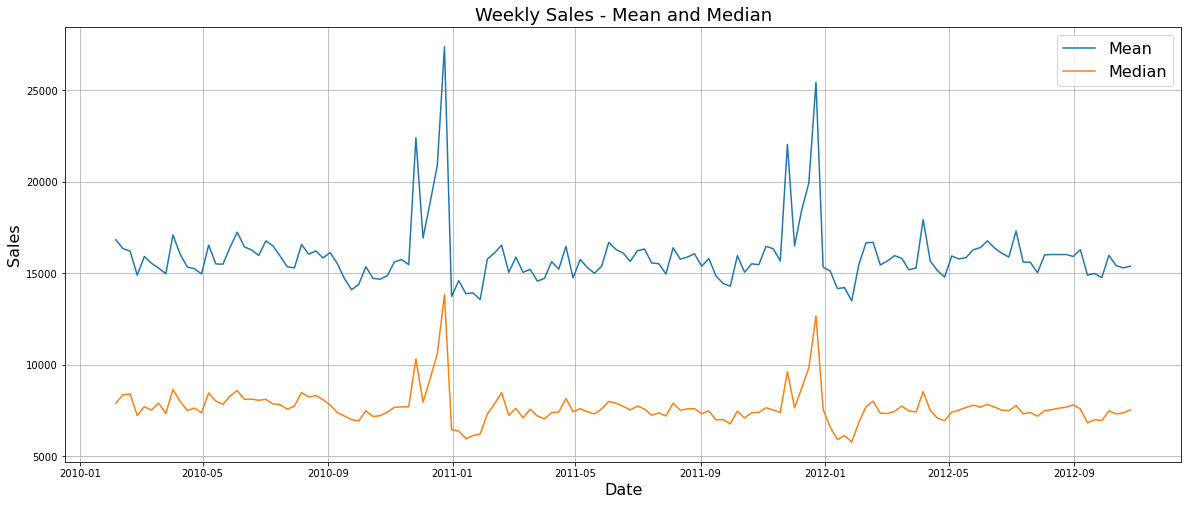

In [12]:
weekly_sales_mean = train_detail['Weekly_Sales'].groupby(train_detail['Date']).mean()
weekly_sales_median = train_detail['Weekly_Sales'].groupby(train_detail['Date']).median()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_mean.index, weekly_sales_mean.values)
sns.lineplot(weekly_sales_median.index, weekly_sales_median.values)
plt.grid()
plt.legend(['Mean', 'Median'], loc='best', fontsize=16)
plt.title('Weekly Sales - Mean and Median', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

Observe the divergence between the mean and median, this suggests that some stores/departments might sell much more than others.

#### Average Sales per Store and Department

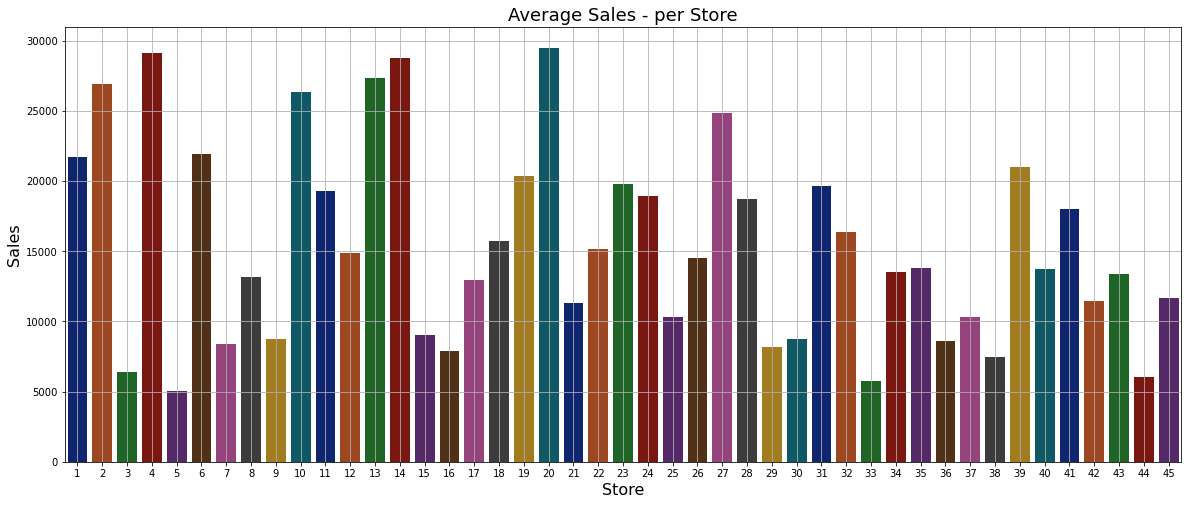

In [13]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Store']).mean()
plt.figure(figsize=(20,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

The graph confrims our suspicion; there is a high degree of Sales variance between stores.  

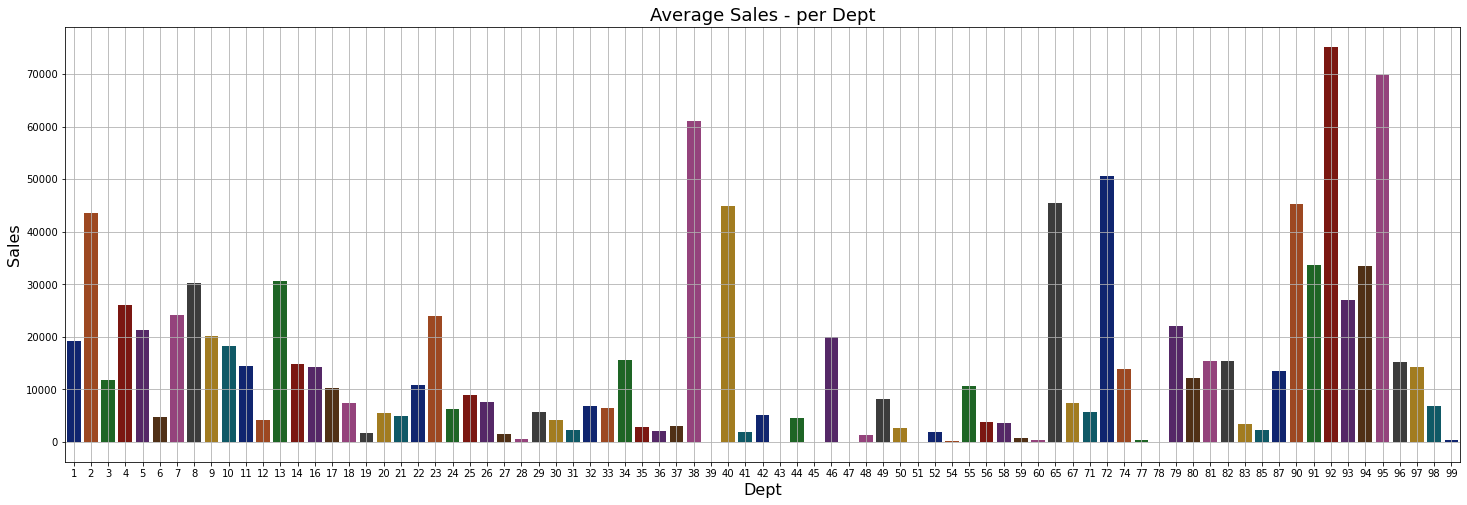

In [12]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Dept']).mean()
plt.figure(figsize=(25,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Dept', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Dept', fontsize=16)
plt.show()

There are Sales difference between the Departments too. Also some Depts are not in the list, like number '15', for example.

#### Variables Correlation

Let's see the correlation between variables, using Pearson Correlation.

Correlation Metrics:
- 0: no correlation at all
- 0-0.3: weak correlation
- 0.3-0.7: moderate correlaton
- 0.7-1: strong correlation

Positive Correlation indicates that when one variable increase, the other also does. Negative is the opposite.

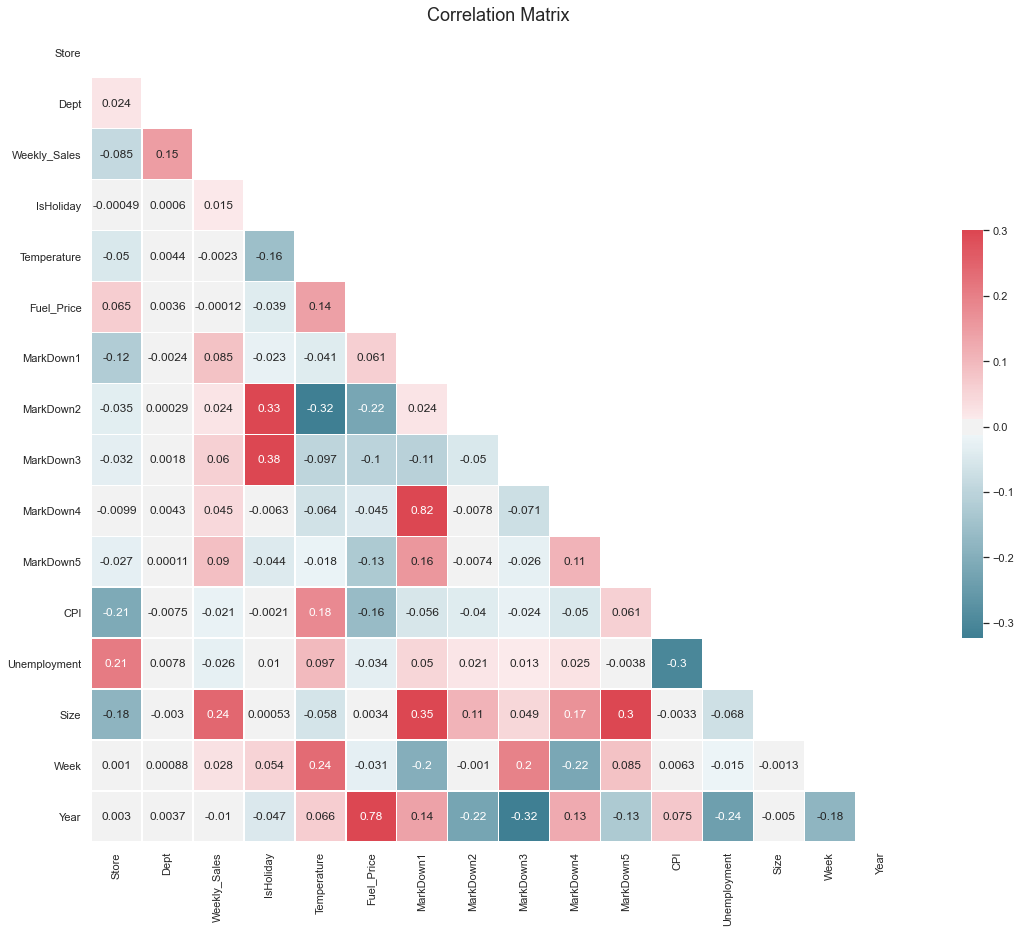

In [14]:
sns.set(style="white")

corr = train_detail.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(20, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

'MarkDown' 1 to 5 are not strongly correlated to 'Weekly_Sales'. Also considering the significant amount of missing data we can drop them from our model.
- Side Note, the underwhelming effect of markdowns suggests a separate study of the relative effect of markdowns. Perhaps markdowns are disregard by consumers when competing retailers offer similar markdowns.  

Also, 'Fuel_Price' is strongly correlated to 'Year'. One must be dropped to avoid collinearity erros in the model. 'Year' will not be dropped, because it differentiate same Weeks for 'Store'+'Dept'. Fuel_Price also has a near zero correlation with sales. 

Other variables that have weak correlation with 'Weekly_Sales' can be analyzed for useful.

In [15]:
train_detail = train_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])
test_detail = test_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])

#### Analyzing Variables

First, two plot functions that will help us.

The discrete plot is for finite numbers. We will use boxplot, to see the medians and interquartile ranges, and the striplot, which is a better way of seeing the distribution, even more when lots of outliers are present.

The continuous plot, as the name says, is for continuous variables. We will see the distribution of probabilities and use BoxCox to understand if there is increase of correlation and decrease of skewness for each variable. In some cases the process of transforming a variable can help, depending on the model.

In [16]:
def make_discrete_plot(feature):
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(1,2)
    sns.boxplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,0]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    sns.stripplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,1]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    fig.show()

In [17]:
def make_continuous_plot(feature):
    
    fig = plt.figure(figsize=(18,15))
    gs = GridSpec(2,2)
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.15), ax=fig.add_subplot(gs[0,1]), palette = 'blue')

    plt.title('BoxCox 0.15\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.15)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.15), nan_policy='omit'),2)))
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.25), ax=fig.add_subplot(gs[1,0]), palette = 'blue')

    plt.title('BoxCox 0.25\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.25)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.25), nan_policy='omit'),2)))
    
    j = sns.distplot(train_detail[feature], ax=fig.add_subplot(gs[1,1]), color = 'green')

    plt.title('Distribution\n')
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=train_detail[feature], ax=fig.add_subplot(gs[0,0]), color = 'red')

    plt.title('Linear\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(train_detail[feature]),2)) + ', Skew: ' + 
               str(np.round(stats.skew(train_detail[feature], nan_policy='omit'),2)))
    
    fig.show()

#### Weekly_Sales x IsHoliday

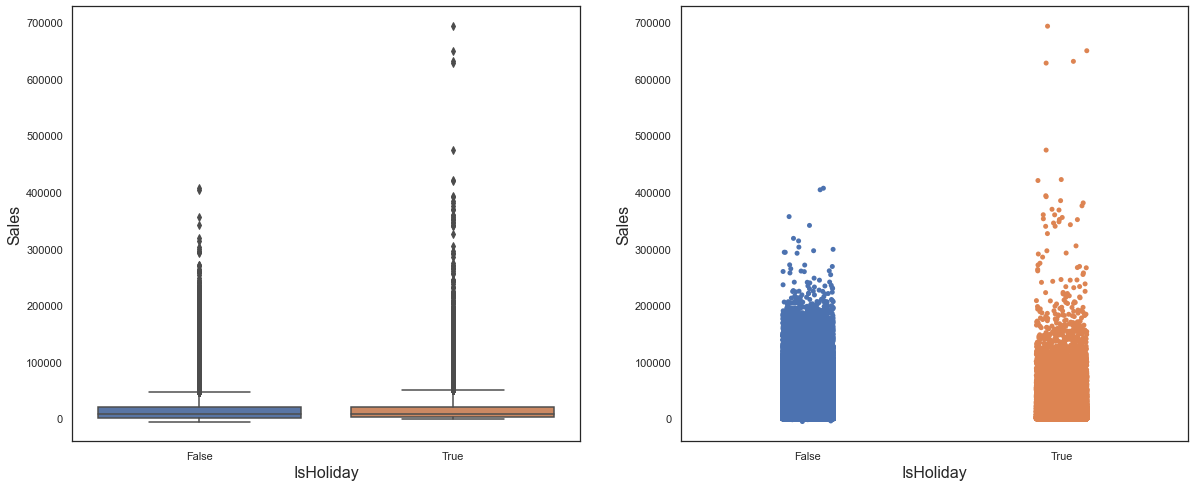

In [18]:
make_discrete_plot('IsHoliday')

This field is going to be important to differentiate Week Holidays. As we can see, Week Holidays have more high sales events than non-Holiday Weeks.

#### Weekly_Sales x Type

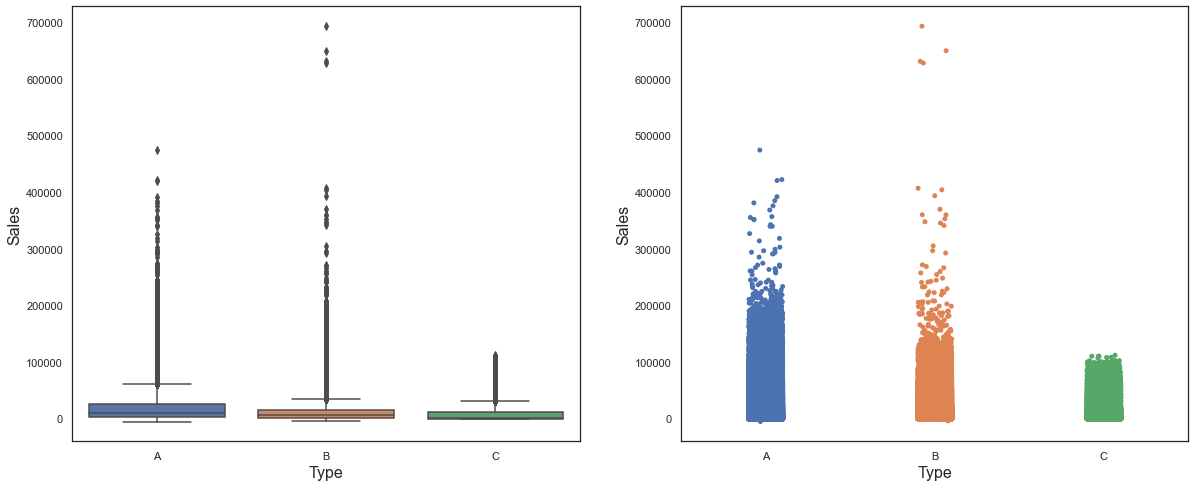

In [19]:
make_discrete_plot('Type')

We don't know what 'Type' is, but we can assume that A > B > C in terms of Sales Median. So, let's treat it as an ordinal variable and replace its values.

Ordinal variables are explained in the figure below.

In [20]:
train_detail.Type = train_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))
test_detail.Type = test_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))

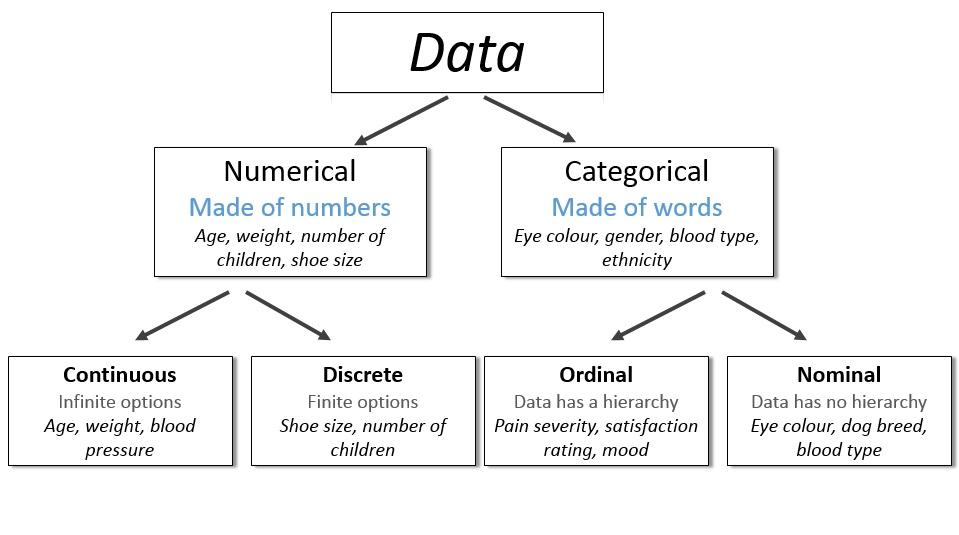

#### Weekly_Sales x Temperature

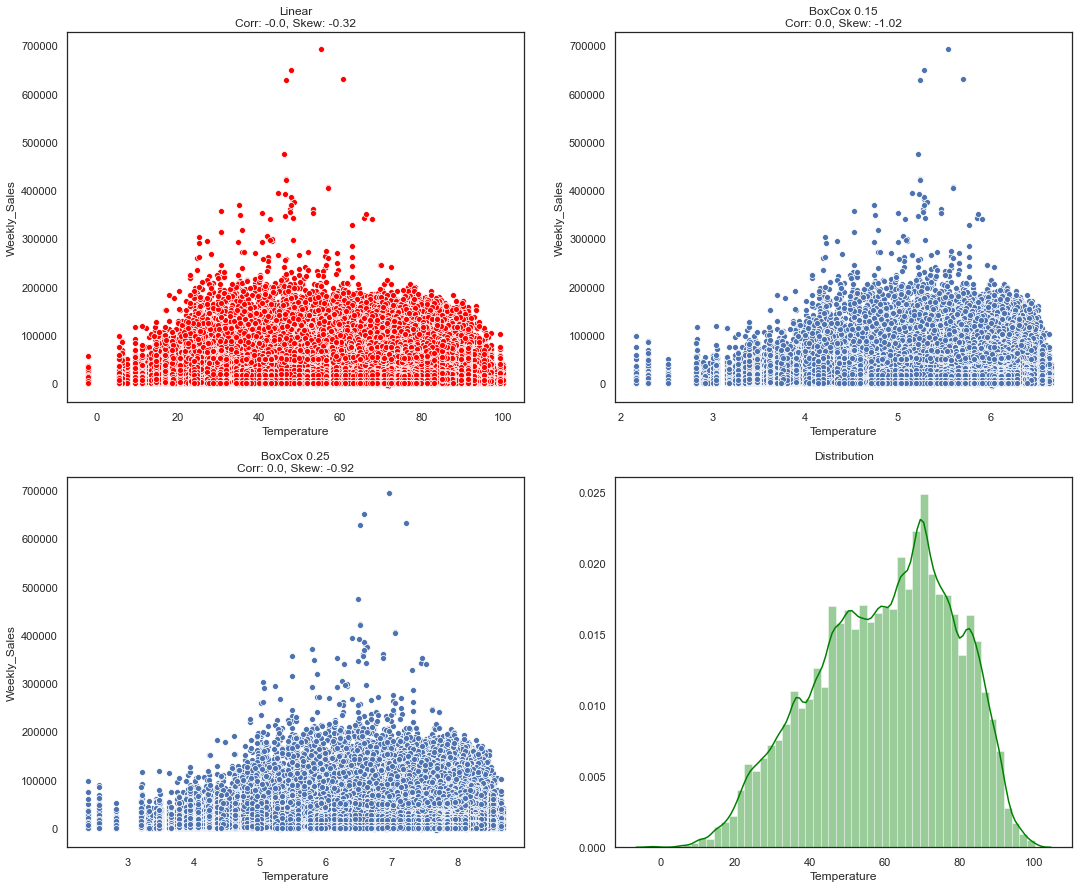

In [21]:
make_continuous_plot('Temperature')

Although skewness changes, correlation doesn't seem to change at all. We can decide to drop it.

In [22]:
train_detail = train_detail.drop(columns=['Temperature'])
test_detail = test_detail.drop(columns=['Temperature'])

#### Weekly_Sales x CPI

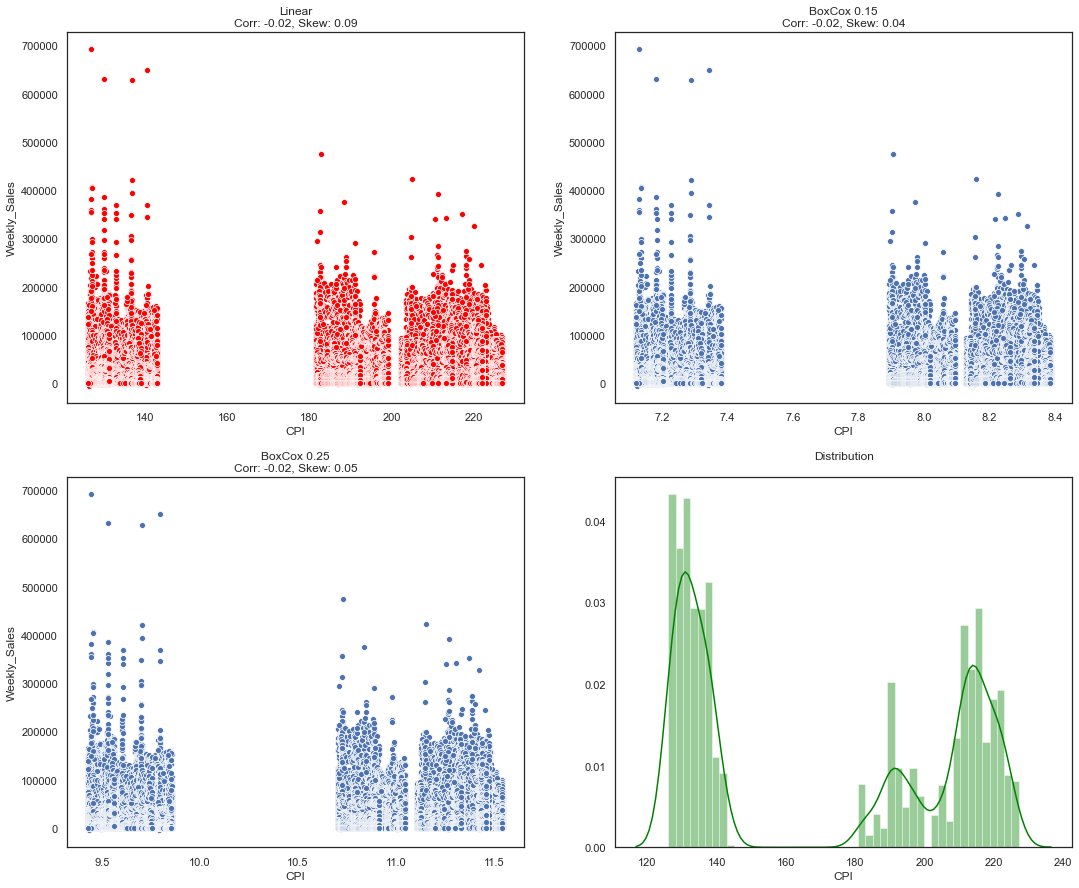

In [23]:
make_continuous_plot('CPI')

Again no strong indication of correlation so CPI can be dropped from the model. 

In [24]:
train_detail = train_detail.drop(columns=['CPI'])
test_detail = test_detail.drop(columns=['CPI'])

#### Weekly_Sales x Unemployment

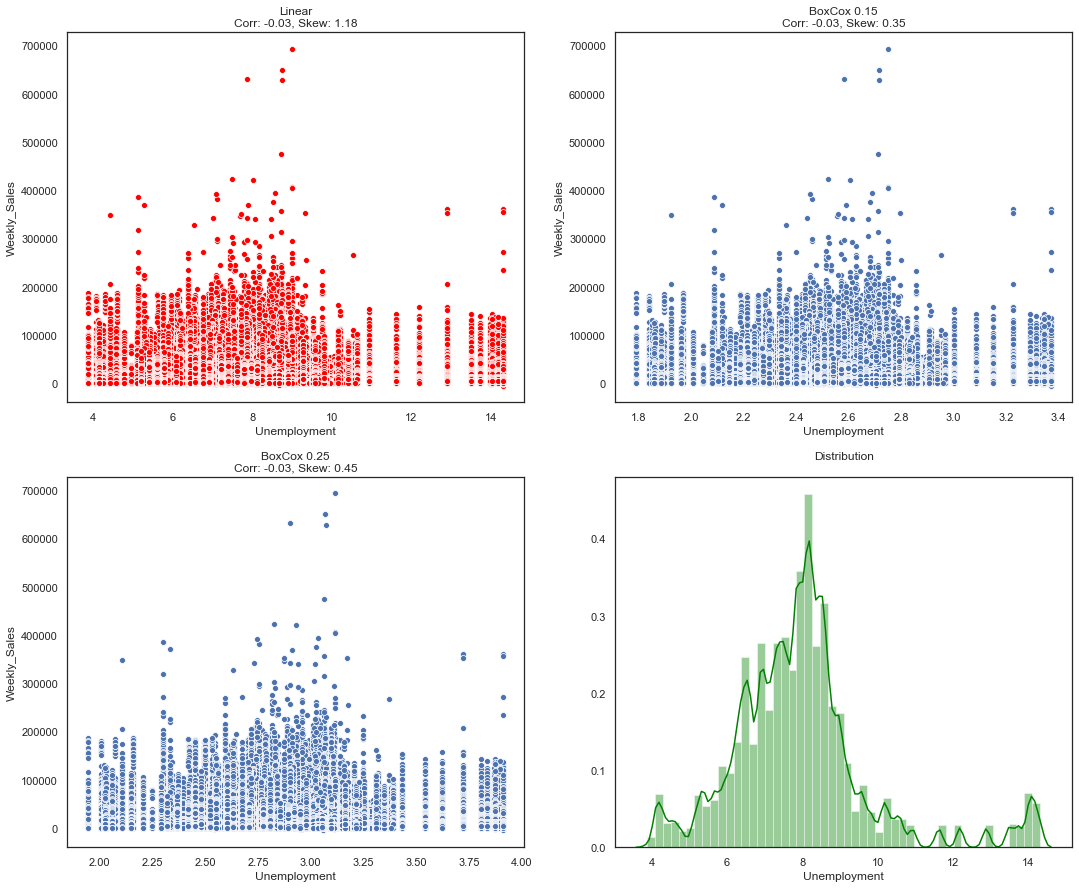

In [25]:
make_continuous_plot('Unemployment')

Same for 'Unemployment' rate.

In [26]:
train_detail = train_detail.drop(columns=['Unemployment'])
test_detail = test_detail.drop(columns=['Unemployment'])

#### Weekly_Sales x Size

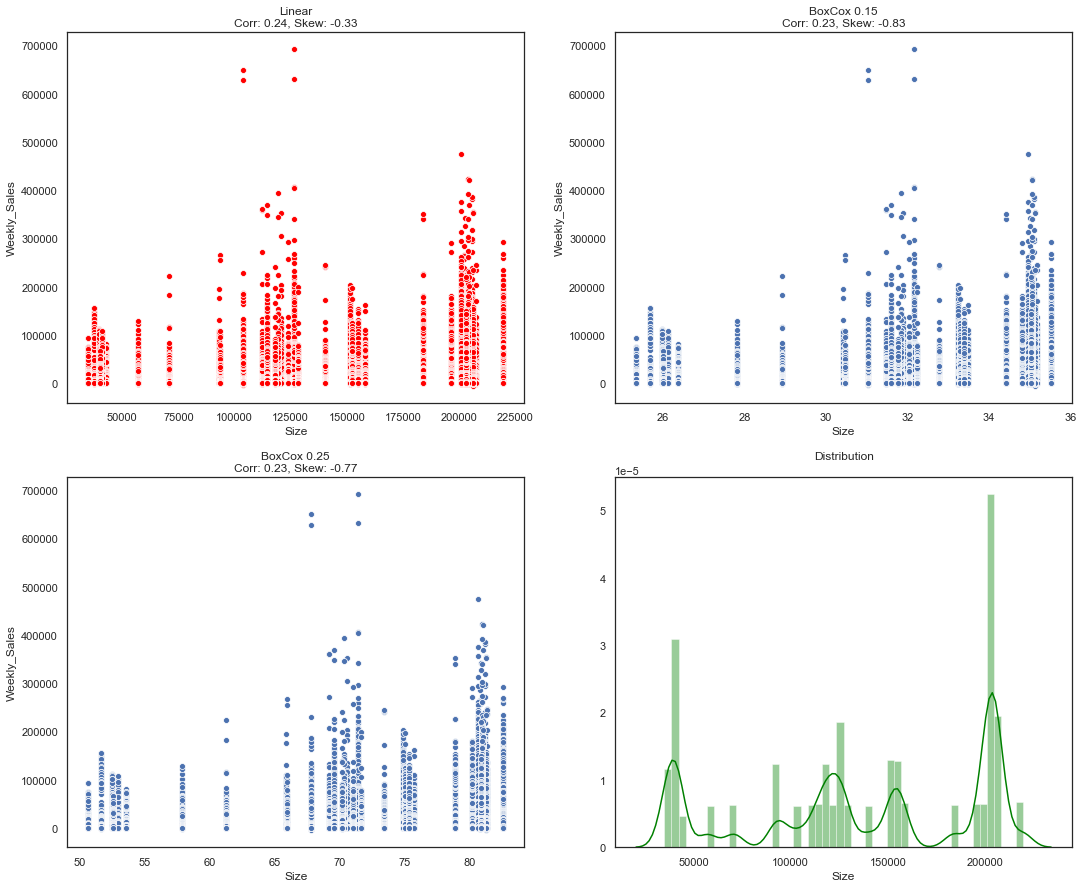

In [27]:
make_continuous_plot('Size')

Store size shows moderate correlation so I'll retain this variable.

## Machine Learning Model

#### Model Functions

Walmart instructed that evaluation would be based on Weighted Mean Absolute Error (WMAE), with a weight of 5 for Holiday Weeks and 1 otherwise. To this end I will train the model to minimize the WMAE. 

Although WMAE is a useful metric for comparing models it can be insufficient when describing accuracy to non-technical users. For this reason I will also describe the accuracy of the model with the Weighted Mean Absolute Percentage Error (WMAPE) in the results section.

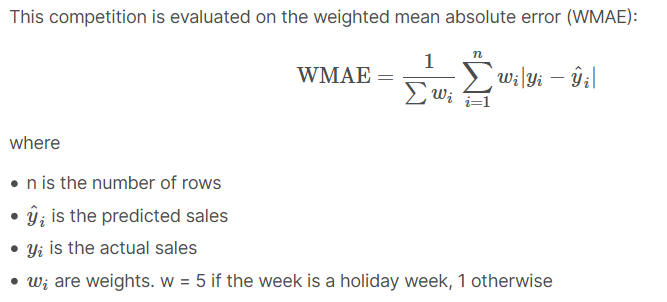

Now to convert WMAE into a function

In [28]:
def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

The model chosen for this project is the Random Forest Regressor. It is an ensemble method and uses multiples decision trees ('n_estimators' parameter of the model) to determine final output, which is an average of the outputs of all trees.

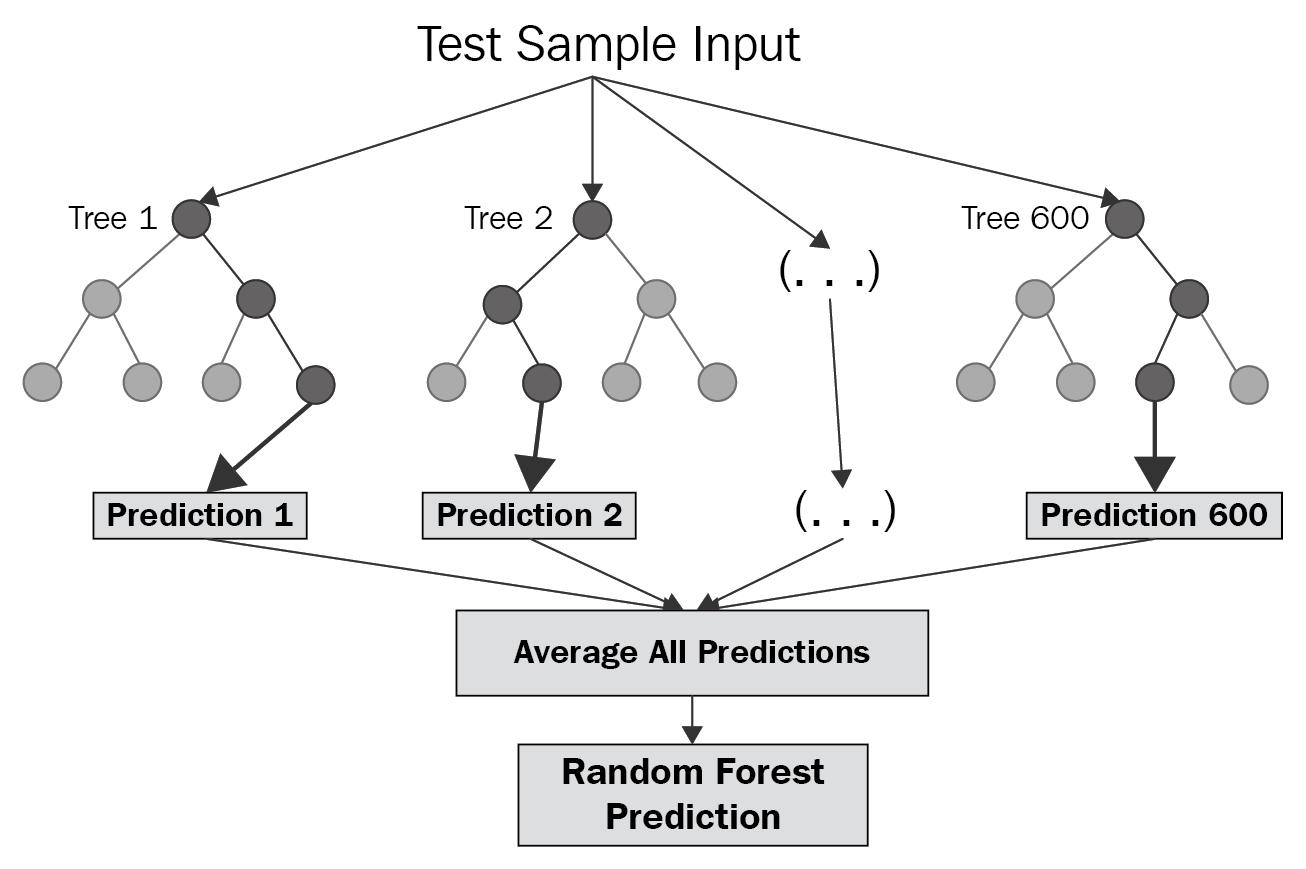

The structure of each decision tree is shown below. 

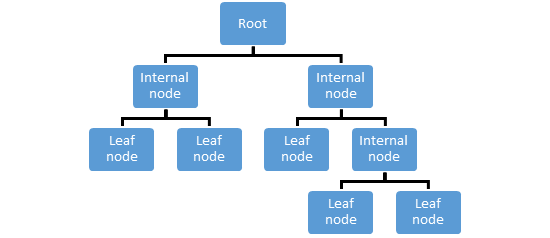


Each decision tree starts with a feature that is the Root. The tree then procedes to split the sample data into smaller partitions to generate predictions, and continues to split until the max depth is reached. The algorithm determines each split by optimizing for: more predictiveness, less impurity, and lower entropy. The following hyperparameters inform the structure of these decision trees and are tuned to improve the model. 

- min_samples_split, min number of data points placed in a node before the node is split
- min_samples_leaf, min number of data points allowed in a leaf node
- max_features, max number of features considered for splitting a node
- max_depth, max number of levels in each decision tree
- n_estimators, number of trees in the foreset


It is important to tune these parameters to find the best predictor and to minimize overfitting.

The functions for Random Forest, Parameters Tuning and Cross Validation are:

In [29]:
def random_forest(n_estimators, max_depth):
    result = []
    for estimator in n_estimators:
        for depth in max_depth:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', n_estimators:', estimator, ', max_depth:', depth)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Max_Depth': depth, 'Estimators': estimator, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [30]:
def random_forest_II(n_estimators, max_depth, max_features):
    result = []
    for feature in max_features:
        wmaes_cv = []
        for i in range(1,5):
            print('k:', i, ', max_features:', feature)
            x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
            RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=feature)
            RF.fit(x_train, y_train)
            predicted = RF.predict(x_test)
            wmaes_cv.append(WMAE(x_test, y_test, predicted))
        print('WMAE:', np.mean(wmaes_cv))
        result.append({'Max_Feature': feature, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [31]:
def random_forest_III(n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf):
    result = []
    for split in min_samples_split:
        for leaf in min_samples_leaf:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', min_samples_split:', split, ', min_samples_leaf:', leaf)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, 
                                           min_samples_leaf=leaf, min_samples_split=split)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Min_Samples_Leaf': leaf, 'Min_Samples_Split': split, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

#### Training Model

Prepare the training data set.

In [32]:
X_train = train_detail[['Store','Dept','IsHoliday','Size','Week','Type','Year']]
Y_train = train_detail['Weekly_Sales']

Tuning 'n_estimators' and 'max_depth'.

Here, it is possible to test a lot of values. Those are the final ones, after a bit of testing.

In [33]:
n_estimators = [56, 58, 60]
max_depth = [25, 27, 30]

random_forest(n_estimators, max_depth)

k: 1 , n_estimators: 56 , max_depth: 25
k: 2 , n_estimators: 56 , max_depth: 25
k: 3 , n_estimators: 56 , max_depth: 25
k: 4 , n_estimators: 56 , max_depth: 25
WMAE: 1545.0700000000002
k: 1 , n_estimators: 56 , max_depth: 27
k: 2 , n_estimators: 56 , max_depth: 27
k: 3 , n_estimators: 56 , max_depth: 27
k: 4 , n_estimators: 56 , max_depth: 27
WMAE: 1534.1625
k: 1 , n_estimators: 56 , max_depth: 30
k: 2 , n_estimators: 56 , max_depth: 30
k: 3 , n_estimators: 56 , max_depth: 30
k: 4 , n_estimators: 56 , max_depth: 30
WMAE: 1548.1499999999999
k: 1 , n_estimators: 58 , max_depth: 25
k: 2 , n_estimators: 58 , max_depth: 25
k: 3 , n_estimators: 58 , max_depth: 25
k: 4 , n_estimators: 58 , max_depth: 25
WMAE: 1535.0649999999998
k: 1 , n_estimators: 58 , max_depth: 27
k: 2 , n_estimators: 58 , max_depth: 27
k: 3 , n_estimators: 58 , max_depth: 27
k: 4 , n_estimators: 58 , max_depth: 27
WMAE: 1556.1025000000002
k: 1 , n_estimators: 58 , max_depth: 30
k: 2 , n_estimators: 58 , max_depth: 30
k: 3

,Max_Depth,Estimators,WMAE
0,25,56,1545.0700
1,27,56,1534.1625
2,30,56,1548.1500
3,25,58,1535.0650
4,27,58,1556.1025
5,30,58,1552.5600
6,25,60,1554.8075
7,27,60,1563.7300
8,30,60,1544.5900


The result by the time I run it is 58 and 27.

Tuning 'max_features'.

In [34]:
max_features = [2, 3, 4, 5, 6, 7]

random_forest_II(n_estimators=58, max_depth=27, max_features=max_features)

k: 1 , max_features: 2
k: 2 , max_features: 2
k: 3 , max_features: 2
k: 4 , max_features: 2
WMAE: 4537.405
k: 1 , max_features: 3
k: 2 , max_features: 3
k: 3 , max_features: 3
k: 4 , max_features: 3
WMAE: 2627.9275
k: 1 , max_features: 4
k: 2 , max_features: 4
k: 3 , max_features: 4
k: 4 , max_features: 4
WMAE: 1803.985
k: 1 , max_features: 5
k: 2 , max_features: 5
k: 3 , max_features: 5
k: 4 , max_features: 5
WMAE: 1573.98
k: 1 , max_features: 6
k: 2 , max_features: 6
k: 3 , max_features: 6
k: 4 , max_features: 6
WMAE: 1536.5725
k: 1 , max_features: 7
k: 2 , max_features: 7
k: 3 , max_features: 7
k: 4 , max_features: 7
WMAE: 1536.8700000000001


,Max_Feature,WMAE
0,2,4537.4050
1,3,2627.9275
2,4,1803.9850
3,5,1573.9800
4,6,1536.5725
5,7,1536.8700


The result by the time I run it is 6.

Tuning 'min_samples_split' and 'min_samples_leaf'.

In [35]:
min_samples_split = [2, 3, 4]
min_samples_leaf = [1, 2, 3]

random_forest_III(n_estimators=58, max_depth=27, max_features=6, 
                  min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

k: 1 , min_samples_split: 2 , min_samples_leaf: 1
k: 2 , min_samples_split: 2 , min_samples_leaf: 1
k: 3 , min_samples_split: 2 , min_samples_leaf: 1
k: 4 , min_samples_split: 2 , min_samples_leaf: 1
WMAE: 1541.8575
k: 1 , min_samples_split: 2 , min_samples_leaf: 2
k: 2 , min_samples_split: 2 , min_samples_leaf: 2
k: 3 , min_samples_split: 2 , min_samples_leaf: 2
k: 4 , min_samples_split: 2 , min_samples_leaf: 2
WMAE: 1590.72
k: 1 , min_samples_split: 2 , min_samples_leaf: 3
k: 2 , min_samples_split: 2 , min_samples_leaf: 3
k: 3 , min_samples_split: 2 , min_samples_leaf: 3
k: 4 , min_samples_split: 2 , min_samples_leaf: 3
WMAE: 1635.6775
k: 1 , min_samples_split: 3 , min_samples_leaf: 1
k: 2 , min_samples_split: 3 , min_samples_leaf: 1
k: 3 , min_samples_split: 3 , min_samples_leaf: 1
k: 4 , min_samples_split: 3 , min_samples_leaf: 1
WMAE: 1534.45
k: 1 , min_samples_split: 3 , min_samples_leaf: 2
k: 2 , min_samples_split: 3 , min_samples_leaf: 2
k: 3 , min_samples_split: 3 , min_sample

,Min_Samples_Leaf,Min_Samples_Split,WMAE
0,1,2,1541.8575
1,2,2,1590.7200
2,3,2,1635.6775
3,1,3,1534.4500
4,2,3,1600.1125
5,3,3,1633.4125
6,1,4,1577.8175
7,2,4,1597.9550
8,3,4,1643.6550


The result by the time I run it is 3 and 1.

In [36]:
RF = RandomForestRegressor(n_estimators=58, max_depth=27, max_features=6, min_samples_split=3, min_samples_leaf=1)
RF.fit(X_train, Y_train)

RandomForestRegressor(max_depth=27, max_features=6, min_samples_split=3,
                      n_estimators=58)

## Predictions

Now to generate predictions:

In [ ]:
X_train = train_detail[['Store','Dept','IsHoliday','Size','Week','Type','Year']]
predict = RF.predict(X_train)


## Results



Now to assess and communicate the accuracy of this model I calculated the Weighted Mean Absolute Percentage Error (WMAPE)

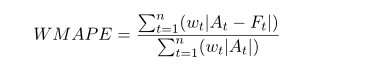

Due to format inconsistancies I exported the 'predict' forecast results and actual sales detail into R where I was more comfrotable computing WMAPE. 

In [ ]:
library(readr)
predict <- read_csv("Documents/Jupyter Storage/Walmart Forecasting/predict.txt")
detail <- read_table2("Documents/Jupyter Storage/Walmart Forecasting/detail.txt")
P<- predict 
P$Point <- seq.int(nrow(P))
D <- detail
D$W  <- ifelse(grepl("TRUE", D$IsHoliday), "5", "1")
D$Point <- seq.int(nrow(D))
F <- merge(D,P, by="Point")
F$Dif <- abs(F$Weekly_Sales-F2$Sales)
F$Nr <-  F$W * F$Dif
F$Dr <- abs(F$Weekly_Sales)*F$W
sum(F$Nr)/sum(F$Dr)

[1] 0.04056771


As we can see the WMAPE = 0.04056771, approximately 4.1%. This figure is much easier to comprehend than say a WMAE of 1541.8575. In this context Weighted Average Percentage Error (WMAPE) communicates the inaccuracy of sales predictions while emphasizing the importance of the holiday sales season. If the model perfectly predicted sales the WMAPE would be 0.This error metric can also convey accuracy by subtracting it from one.

### Results Summary

Walmart required a more accuracte method for predicting store sales down to the department level. Improved prediction accuracy will enable Walmart to capture significant returns across business lines. Efficieny gains can be obtained from improved channel inventory management, minimized operational costs, and informed marketing intiatives. To this end I created a random forest regression model that's proven to predict stores sales with 95.9% accuracy. With continued supervision this machine learning technique can be expanded across the scrope of Walmart's business for exceptional returns. 
